In [138]:
# Import of relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#system access 
import os
import sys
sys.path.append("..")

# Preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# modelling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from xgboost import plot_importance


#metrics
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import fbeta_score, make_scorer

plt.style.use('seaborn')

RSEED = 42

#saving the modell
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
# # load the data set from CSV file
HDD_ST4000DM000= pd.read_csv('../src/data/data/processed/ST4000DM000_history_total_preprocessed.csv', parse_dates=['date'])

In [4]:
HDD_original= pd.read_csv('../src/data/data/raw/ST4000DM000_history_total.csv', parse_dates=['date'])

In [5]:
print(list(HDD_original.columns[HDD_original.columns.str.contains("smart")]))

['smart_1_normalized', 'smart_1_raw', 'smart_2_normalized', 'smart_2_raw', 'smart_3_normalized', 'smart_3_raw', 'smart_4_normalized', 'smart_4_raw', 'smart_5_normalized', 'smart_5_raw', 'smart_7_normalized', 'smart_7_raw', 'smart_8_normalized', 'smart_8_raw', 'smart_9_normalized', 'smart_9_raw', 'smart_10_normalized', 'smart_10_raw', 'smart_11_normalized', 'smart_11_raw', 'smart_12_normalized', 'smart_12_raw', 'smart_13_normalized', 'smart_13_raw', 'smart_15_normalized', 'smart_15_raw', 'smart_16_normalized', 'smart_16_raw', 'smart_17_normalized', 'smart_17_raw', 'smart_18_normalized', 'smart_18_raw', 'smart_22_normalized', 'smart_22_raw', 'smart_23_normalized', 'smart_23_raw', 'smart_24_normalized', 'smart_24_raw', 'smart_160_normalized', 'smart_160_raw', 'smart_161_normalized', 'smart_161_raw', 'smart_163_normalized', 'smart_163_raw', 'smart_164_normalized', 'smart_164_raw', 'smart_165_normalized', 'smart_165_raw', 'smart_166_normalized', 'smart_166_raw', 'smart_167_normalized', 'sma

In [6]:
HDD_ST4000DM000.head()

,date,serial_number,model,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_failure,countdown
0,2020-09-18,Z304JG86,ST4000DM000,0,115.0,93783288.0,91.0,13.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,42329.0,5.519570e+10,2.709359e+11,2020-11-07,50
1,2020-09-18,S301GMGZ,ST4000DM000,0,113.0,55185864.0,91.0,13.0,100.0,0.0,...,100.0,16.0,100.0,16.0,0.0,42778.0,5.982921e+10,2.557590e+11,2021-05-31,255
2,2020-09-18,S300YQTN,ST4000DM000,0,118.0,170426904.0,94.0,6.0,100.0,0.0,...,100.0,16.0,100.0,16.0,0.0,46671.0,6.363719e+10,2.580255e+11,2021-05-28,252
3,2020-09-18,Z302T8AB,ST4000DM000,0,117.0,119029336.0,92.0,27.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,43845.0,6.252935e+10,2.568232e+11,2020-12-04,77
4,2020-09-18,Z302SXFH,ST4000DM000,0,108.0,18778216.0,92.0,8.0,100.0,0.0,...,100.0,0.0,100.0,0.0,57.0,44350.0,6.250835e+10,2.357636e+11,2020-09-22,4


In [7]:
# Define pollution labels and range cut offs
Failing_labels = ["Fail in 30 days", "Will work more than 30 days"]
Failing_bins = [-1, 30, 800]

#Create new Failing_labels variable
HDD_ST4000DM000["Failing_labels"] = pd.cut(HDD_ST4000DM000["countdown"], bins = Failing_bins, labels=Failing_labels)

In [8]:
def classification_target(cols):
    """function to adjust the previously created "fail_30" column and transform data based on the previous data into 0 or 1
    if value is <= 30, the value is transformed into 1
    if value is > 30, the value is transformed into 0

    Args:
        cols: takes as an argument the panads column specified before the apply method

    Returns:
        int: 0 or 1 based on the previous information
    """
    classification = cols[0]

    if classification <= 30:
        return 1
    if classification > 30:
        return 0

In [9]:
HDD_ST4000DM000['Failing_as_int'] = HDD_ST4000DM000[['countdown']].apply(classification_target, axis=1)

In [10]:
HDD_ST4000DM000.Failing_as_int.dtype

dtype('int64')

In [11]:
HDD_ST4000DM000.head()

,date,serial_number,model,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_198_normalized,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_failure,countdown,Failing_labels,Failing_as_int
0,2020-09-18,Z304JG86,ST4000DM000,0,115.0,93783288.0,91.0,13.0,100.0,0.0,...,100.0,0.0,0.0,42329.0,5.519570e+10,2.709359e+11,2020-11-07,50,Will work more than 30 days,0
1,2020-09-18,S301GMGZ,ST4000DM000,0,113.0,55185864.0,91.0,13.0,100.0,0.0,...,100.0,16.0,0.0,42778.0,5.982921e+10,2.557590e+11,2021-05-31,255,Will work more than 30 days,0
2,2020-09-18,S300YQTN,ST4000DM000,0,118.0,170426904.0,94.0,6.0,100.0,0.0,...,100.0,16.0,0.0,46671.0,6.363719e+10,2.580255e+11,2021-05-28,252,Will work more than 30 days,0
3,2020-09-18,Z302T8AB,ST4000DM000,0,117.0,119029336.0,92.0,27.0,100.0,0.0,...,100.0,0.0,0.0,43845.0,6.252935e+10,2.568232e+11,2020-12-04,77,Will work more than 30 days,0
4,2020-09-18,Z302SXFH,ST4000DM000,0,108.0,18778216.0,92.0,8.0,100.0,0.0,...,100.0,0.0,57.0,44350.0,6.250835e+10,2.357636e+11,2020-09-22,4,Fail in 30 days,1


### Train / Test split

#### Checking again for duplicates and get rid of them

In [12]:
#checking for duplicates
a = HDD_ST4000DM000.query('failure == 1')['serial_number'].to_list()
print(len(a))
a_set = set(a)
print(len(a_set))
a_dup=[]
for serial in a_set:
    a.remove(serial)
print(a)

610
608
['Z302SQFX', 'Z303VDR4']


In [13]:
# query the duplicates (SAME SERIALS WITH FAIL = 1) and add them to a list (there are only 2 of each)
duplicate = HDD_ST4000DM000.query("serial_number == 'Z302SQFX' and failure == 1").index.values.tolist()
duplicate_2 = HDD_ST4000DM000.query("serial_number == 'Z303VDR4' and failure == 1").index.values.tolist()
duplicate_2 

#remove last item from created lists
drop_rows = duplicate.pop() 
drop_rows2 = duplicate_2.pop()

#drop the created rows
HDD_ST4000DM000.drop(drop_rows, axis=0, inplace=True)
HDD_ST4000DM000.drop(drop_rows2, axis=0, inplace=True)

In [14]:
# We have a look on the all the duplicates identified by the Serial column
HDD_ST4000DM000["serial_number"].duplicated()
duplicate_id = HDD_ST4000DM000.groupby("serial_number").size().to_frame('Count').reset_index()
duplicate_id = duplicate_id.sort_values('Count', ascending=False)
duplicate_id.head(10)

,serial_number,Count
333,Z304GSQ0,1096
511,Z305AQQP,1095
211,Z302SWBN,1091
593,Z305K296,1089
607,Z307XHRJ,1087
153,W301BY50,1086
353,Z304HWNT,1085
599,Z305MM0G,1084
157,Z3026ZSL,1084
453,Z304KQXL,1084


In [15]:
#Preparing a DF based on unique Serial numbers for filtering and splitting the data in a proper way
df1 = pd.DataFrame(HDD_ST4000DM000.serial_number.unique(), columns=['Serial_unique'])

df1

,Serial_unique
0,Z304JG86
1,S301GMGZ
2,S300YQTN
3,Z302T8AB
4,Z302SXFH
...,...
603,Z305FDYS
604,Z304K6EG
605,S300ZV6H
606,Z302A12A


### Import new created features (unwrapped, trigger)

In [16]:
from src.features.feature_engineering import create_features

In [17]:
HDD_ST4000DM000 = create_features(HDD_ST4000DM000, interval=30, trigger_percentage=0.05)

  0%|          | 0/608 [00:00<?, ?it/s]../src/features/feature_engineering.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.smart_7_mod[temp_data.index] = temp_data.smart_7_raw
  0%|          | 1/608 [00:00<01:59,  5.07it/s]../src/features/feature_engineering.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.smart_7_mod[temp_data.index] = temp_data.smart_7_raw
../src/features/feature_engineering.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [18]:
HDD_ST4000DM000.head()


,date,serial_number,model,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,...,smart_184_raw_trigger,smart_187_raw_trigger,smart_188_raw_trigger,smart_189_raw_trigger,smart_193_raw_trigger,smart_192_raw_trigger,smart_197_raw_trigger,smart_198_raw_trigger,smart_199_raw_trigger,smart_999
0,2020-09-18,Z304JG86,ST4000DM000,0,93783288.0,13.0,0.0,208544989.0,42390.0,13.0,...,False,False,False,False,False,False,False,False,False,0
1,2020-09-18,S301GMGZ,ST4000DM000,0,55185864.0,13.0,0.0,586510565.0,42857.0,13.0,...,False,True,False,False,False,False,True,True,False,3
2,2020-09-18,S300YQTN,ST4000DM000,0,170426904.0,6.0,0.0,639460780.0,46828.0,6.0,...,False,False,False,False,False,False,False,False,False,0
3,2020-09-18,Z302T8AB,ST4000DM000,0,119029336.0,27.0,0.0,615938251.0,44034.0,27.0,...,False,False,False,False,False,False,False,False,False,0
4,2020-09-18,Z302SXFH,ST4000DM000,0,18778216.0,8.0,0.0,587606218.0,44474.0,8.0,...,False,False,False,False,False,False,False,False,False,0


In [19]:
#create a train/test split with serials based on dummies (80/20)
#creat a list of the separated serials + create a pd.series
RSEED = 200
serial_number_train, serial_number_test, dummy_train, dummy_test = train_test_split(df1['Serial_unique'], df1['Serial_unique'], test_size=0.2, random_state=RSEED)

serial_number_train = pd.Series(serial_number_train)
serial_number_test = pd.Series(serial_number_test)

In [20]:
#Generate the Train and test data based on the splitted serials
df_train = HDD_ST4000DM000[HDD_ST4000DM000["serial_number"].isin(serial_number_train)]
y_train = df_train["Failing_as_int"]
X_train = df_train.drop(["Failing_as_int", "countdown"], axis=1)

# X_train.query('failure == 1').count()
# X_train.query('failure == 1').nunique()


In [21]:
df_test = HDD_ST4000DM000[HDD_ST4000DM000["serial_number"].isin(serial_number_test)]
y_test = df_test["Failing_as_int"]
X_test = df_test.drop(["Failing_as_int", "countdown"], axis=1)

<AxesSubplot:xlabel='Failing_as_int', ylabel='count'>

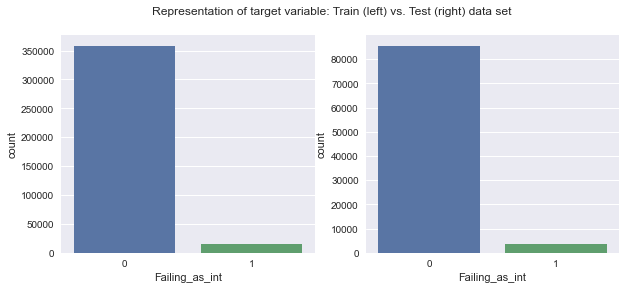

In [22]:
# Visualize y_train and y_test after splitting
fig, axes = plt.subplots(1,2, figsize=(10, 4))
fig.suptitle("Representation of target variable: Train (left) vs. Test (right) data set")
sns.countplot(x=y_train, ax=axes[0])
sns.countplot(x=y_test, ax=axes[1])

In [23]:
# Show dimensions of train and testing data
print(X_train.shape)
print(X_test.shape)

(373587, 65)
(89377, 65)


In [24]:
X_train.head(5)

,date,serial_number,model,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,...,smart_184_raw_trigger,smart_187_raw_trigger,smart_188_raw_trigger,smart_189_raw_trigger,smart_193_raw_trigger,smart_192_raw_trigger,smart_197_raw_trigger,smart_198_raw_trigger,smart_199_raw_trigger,smart_999
0,2020-09-18,Z304JG86,ST4000DM000,0,93783288.0,13.0,0.0,208544989.0,42390.0,13.0,...,False,False,False,False,False,False,False,False,False,0
2,2020-09-18,S300YQTN,ST4000DM000,0,170426904.0,6.0,0.0,639460780.0,46828.0,6.0,...,False,False,False,False,False,False,False,False,False,0
3,2020-09-18,Z302T8AB,ST4000DM000,0,119029336.0,27.0,0.0,615938251.0,44034.0,27.0,...,False,False,False,False,False,False,False,False,False,0
4,2020-09-18,Z302SXFH,ST4000DM000,0,18778216.0,8.0,0.0,587606218.0,44474.0,8.0,...,False,False,False,False,False,False,False,False,False,0
5,2020-09-18,Z3058LG6,ST4000DM000,0,51919976.0,9.0,0.0,717465735.0,41879.0,9.0,...,False,True,False,False,False,False,True,True,False,4


## Preparing the data

In [109]:
#prepare x for modelling (dropping columns)
#list only columns with the string "smart" or "raw" including the new features

Grouping_columns = list(X_train.columns[X_train.columns.str.contains("smart" or "raw")])
#X_train = X_train.drop(['date_failure', 'model', 'serial_number', 'date'], axis=1)

X_train = X_train[Grouping_columns]
X_test = X_test[Grouping_columns]

In [110]:
len(X_train.columns)

56

In [26]:
X_train.isnull().sum()

smart_1_raw              0
smart_4_raw              0
smart_5_raw              0
smart_7_raw              0
smart_9_raw              0
smart_12_raw             0
smart_183_raw            0
smart_184_raw            0
smart_187_raw            0
smart_188_raw            0
smart_189_raw            0
smart_190_raw            0
smart_192_raw            0
smart_193_raw            0
smart_194_raw            0
smart_197_raw            0
smart_198_raw            0
smart_199_raw            0
smart_240_raw            0
smart_241_raw            0
smart_242_raw            0
smart_7_mod              0
smart_1_raw_ema          0
smart_4_raw_ema          0
smart_5_raw_ema          0
smart_7_raw_ema          0
smart_9_raw_ema          0
smart_12_raw_ema         0
smart_183_raw_ema        0
smart_184_raw_ema        0
smart_187_raw_ema        0
smart_188_raw_ema        0
smart_189_raw_ema        0
smart_190_raw_ema        0
smart_192_raw_ema        0
smart_193_raw_ema        0
smart_194_raw_ema        0
s

### Scaling / transformation based on X_train

In [49]:
X_train

,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,smart_188_raw,...,smart_184_raw_trigger,smart_187_raw_trigger,smart_188_raw_trigger,smart_189_raw_trigger,smart_193_raw_trigger,smart_192_raw_trigger,smart_197_raw_trigger,smart_198_raw_trigger,smart_199_raw_trigger,smart_999
0,93783288.0,13.0,0.0,208544989.0,42390.0,13.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,0
2,170426904.0,6.0,0.0,639460780.0,46828.0,6.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,0
3,119029336.0,27.0,0.0,615938251.0,44034.0,27.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,0
4,18778216.0,8.0,0.0,587606218.0,44474.0,8.0,2.0,0.0,0.0,24.0,...,False,False,False,False,False,False,False,False,False,0
5,51919976.0,9.0,0.0,717465735.0,41879.0,9.0,3.0,0.0,14.0,0.0,...,False,True,False,False,False,False,True,True,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462961,156623128.0,10.0,0.0,582799710.0,44450.0,10.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,0
462962,122719704.0,14.0,0.0,278100945.0,40391.0,14.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,0
462963,80393480.0,17.0,0.0,482096327.0,42862.0,17.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,0
462964,205167464.0,13.0,0.0,141022782.0,40206.0,13.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,0


In [84]:
X_train

,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,smart_188_raw,...,smart_184_raw_trigger,smart_187_raw_trigger,smart_188_raw_trigger,smart_189_raw_trigger,smart_193_raw_trigger,smart_192_raw_trigger,smart_197_raw_trigger,smart_198_raw_trigger,smart_199_raw_trigger,smart_999
0,93783288.0,13.0,0.0,208544989.0,42390.0,13.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,0
2,170426904.0,6.0,0.0,639460780.0,46828.0,6.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,0
3,119029336.0,27.0,0.0,615938251.0,44034.0,27.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,0
4,18778216.0,8.0,0.0,587606218.0,44474.0,8.0,2.0,0.0,0.0,24.0,...,False,False,False,False,False,False,False,False,False,0
5,51919976.0,9.0,0.0,717465735.0,41879.0,9.0,3.0,0.0,14.0,0.0,...,False,True,False,False,False,False,True,True,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462961,156623128.0,10.0,0.0,582799710.0,44450.0,10.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,0
462962,122719704.0,14.0,0.0,278100945.0,40391.0,14.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,0
462963,80393480.0,17.0,0.0,482096327.0,42862.0,17.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,0
462964,205167464.0,13.0,0.0,141022782.0,40206.0,13.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,0


In [30]:
#log transformation
X_train_log = X_train.select_dtypes(np.number).apply(lambda x : np.log10(x+1))
X_test_log = X_test.select_dtypes(np.number).apply(lambda x : np.log10(x+1))

In [111]:
# Standardizing the data; MinMax/Standard
scaler_X_train =MinMaxScaler()
scaler_X_train.fit(X_train)
def scale_data_based_on_X_train(train, test):
    '''
    MinMaxScaler to fit and transform train data and transform test data
    '''
    train_scaled = scaler_X_train.transform(train)#.select_dtypes(np.number)) # takes only numerical columns (drop 'location' and 'ID')
    test_scaled = scaler_X_train.transform(test)#.select_dtypes(np.number))
    return train_scaled, test_scaled

In [112]:
# Scaling the data based on X_train
X_train_scaled, X_test_scaled = scale_data_based_on_X_train(X_train, X_test)

In [113]:
X_train_scaled

array([[0.3841399 , 0.07272727, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.69807505, 0.03030303, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.48754867, 0.15757576, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.32929474, 0.0969697 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.8403737 , 0.07272727, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.83460556, 0.06666667, 0.        , ..., 0.        , 0.        ,
        0.11111111]])

## Building and Testing the models

### First try of a few basic models

In [114]:
#features used for baseline model
features_baseline = ['smart_5_raw', 'smart_183_raw', 'smart_187_raw', 'smart_184_raw']

In [35]:
# Define fbeta score with higher weighted recall
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# Define dictionary with several interesting metrics
scorer_dict = {"ftwo_scorer": make_scorer(fbeta_score, beta=2), "accuracy": "accuracy", "precision": "precision", "recall": "recall"}


In [36]:
def model_evaluation(clf, scoring, X_train, y_train):
    
    results = {}
    scores = cross_validate(clf, X_train, y_train, scoring=scoring, cv=5, n_jobs=-1)
    results = {key: [value.mean().round(4), value.std().round(4)] for key, value in scores.items()}
    
    del results['fit_time']
    del results['score_time']
    
    return results

In [ ]:
# Test different types of models
list_of_clf = [LogisticRegression(), KNeighborsClassifier(), SVC(), SGDClassifier(), GaussianNB(),  DecisionTreeClassifier(random_state=42)]
for clf in list_of_clf:
    results = model_evaluation(clf, scorer_dict, X_train[features_baseline], y_train)
    print(clf)
    print("Accuracy  (mean, std):", results["test_accuracy"])
    print("Recall    (mean, std):", results["test_recall"])
    print("Precision (mean, std):", results["test_precision"])
    print("Fbeta     (mean, std):", results["test_ftwo_scorer"])
    print("----"*10)


### Try ensemble methods

#### Random Forest

In [118]:
#Random Forest

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(X_train_scaled, y_train)

n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')


# # Training predictions
train_rf_predictions = model.predict(X_train_scaled)
train_rf_probs = model.predict_proba(X_train_scaled)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = model.predict(X_test_scaled)
rf_probs = model.predict_proba(X_test_scaled)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s


Average number of nodes 3843
Average maximum depth 38


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           0       0.96      0.98      0.97     85605
           1       0.30      0.18      0.23      3772

    accuracy                           0.95     89377
   macro avg       0.63      0.58      0.60     89377
weighted avg       0.94      0.95      0.94     89377

Test Fbeta score with higher weighted recall:  0.199
Test precision_score:  0.29750644883920896
Test roc_auc_score:  0.5821846909245484


<AxesSubplot:>

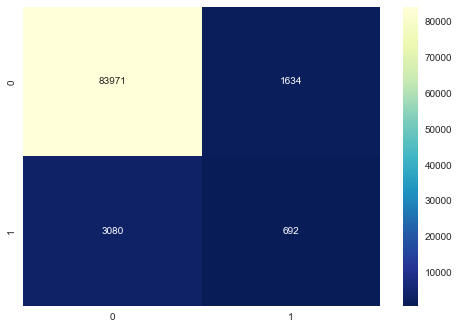

In [119]:
print(classification_report(y_test, rf_predictions))
print("Test Fbeta score with higher weighted recall: ", fbeta_score(y_test, rf_predictions, beta=2).round(3))
print("Test precision_score: ", precision_score(y_test, rf_predictions))
print("Test roc_auc_score: ", roc_auc_score(y_test, rf_predictions))
#roc_curve()

cm = confusion_matrix(y_test, rf_predictions)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f")

/Users/andi/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/andi/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


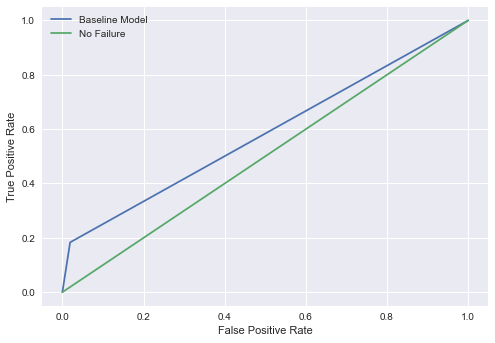

In [120]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, rf_predictions)
base = np.linspace(0,1,100)
sns.lineplot(fpr, tpr)
sns.lineplot(base, base)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["Baseline Model", "No Failure"]);

In [92]:
X_train.columns

Index(['smart_1_raw', 'smart_4_raw', 'smart_5_raw', 'smart_7_raw',
       'smart_9_raw', 'smart_12_raw', 'smart_183_raw', 'smart_184_raw',
       'smart_187_raw', 'smart_188_raw', 'smart_189_raw', 'smart_190_raw',
       'smart_192_raw', 'smart_193_raw', 'smart_194_raw', 'smart_197_raw',
       'smart_198_raw', 'smart_199_raw', 'smart_240_raw', 'smart_241_raw',
       'smart_242_raw', 'smart_1_raw_ema', 'smart_4_raw_ema',
       'smart_5_raw_ema', 'smart_7_raw_ema', 'smart_9_raw_ema',
       'smart_12_raw_ema', 'smart_183_raw_ema', 'smart_184_raw_ema',
       'smart_187_raw_ema', 'smart_188_raw_ema', 'smart_189_raw_ema',
       'smart_190_raw_ema', 'smart_192_raw_ema', 'smart_193_raw_ema',
       'smart_194_raw_ema', 'smart_197_raw_ema', 'smart_198_raw_ema',
       'smart_199_raw_ema', 'smart_240_raw_ema', 'smart_241_raw_ema',
       'smart_242_raw_ema', 'smart_4_raw_trigger', 'smart_5_raw_trigger',
       'smart_12_raw_trigger', 'smart_183_raw_trigger',
       'smart_184_raw_trigger',

   index            Feature  Importance
0     34  smart_193_raw_ema    0.048876
1     41  smart_242_raw_ema    0.047903
2     13      smart_193_raw    0.046949
3     20      smart_242_raw    0.045576
4     25    smart_9_raw_ema    0.044368
5     18      smart_240_raw    0.044262
6     19      smart_241_raw    0.043385
7     40  smart_241_raw_ema    0.042499
8      4        smart_9_raw    0.040493
9     39  smart_240_raw_ema    0.039401
['smart_1_raw', 'smart_4_raw', 'smart_5_raw', 'smart_7_raw', 'smart_9_raw', 'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw', 'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw', 'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw', 'smart_1_raw_ema', 'smart_4_raw_ema', 'smart_5_raw_ema', 'smart_7_raw_ema', 'smart_9_raw_ema', 'smart_12_raw_ema', 'smart_183_raw_ema', 'smart_184_raw_ema', 'smart_187_raw_ema', 'smart_188_raw_ema', 'smart_189_raw

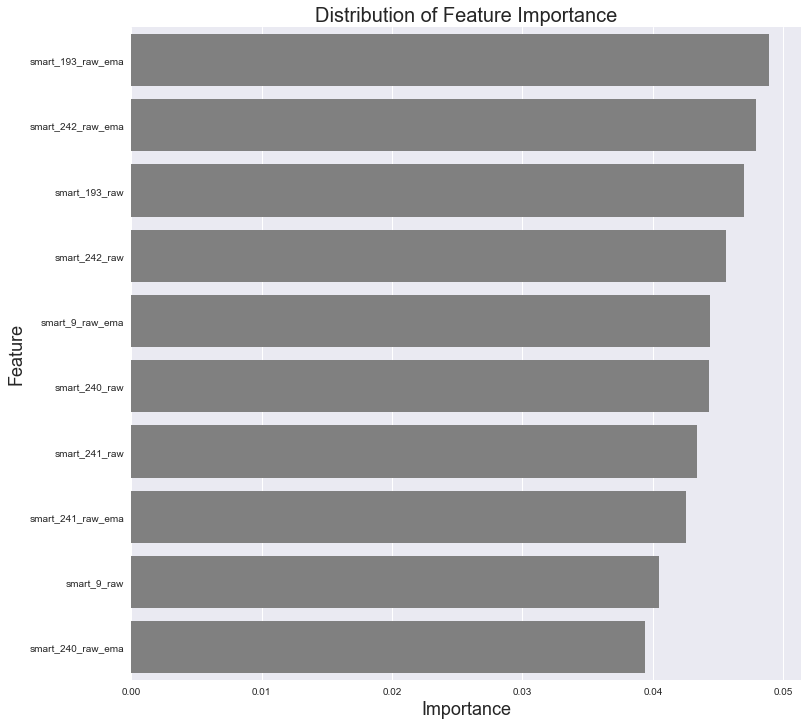

In [131]:
# Extract importance of features
importances = model.feature_importances_

# Create importance data frame and attach feature labels
model_importances = pd.DataFrame({"Feature": X_train.columns, "Importance": importances})

# Sort by ascending order
model_importances = model_importances.sort_values('Importance', ascending=False).reset_index().head(10)

# Plot as barplot
fig, ax = plt.subplots(figsize=(12,12), )
sns.barplot(y="Feature", x="Importance", data=model_importances, color = "grey")
plt.title('Distribution of Feature Importance', fontsize=20)
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)

print(model_importances)
print(list(X_train.columns[X_train.columns.str.contains("raw" or "smart")]))

#### XG Boost

In [139]:
# Fit model to training data
xgb_model = XGBClassifier(random_state = RSEED)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions on test set
train_predictions_xgb = xgb_model.predict(X_test_scaled)
predictions_xgb  = [round(value) for value in train_predictions_xgb]



[14:01:48] WARNING: /private/var/folders/ll/klks76jx1032hcf8s5z8qbkr0000gn/T/pip-install-3ez_r3gx/xgboost_443aaaa50aac46de82a97140ac49194c/build/temp.macosx-12.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


              precision    recall  f1-score   support

           0       0.97      0.96      0.96     85605
           1       0.19      0.22      0.21      3772

    accuracy                           0.93     89377
   macro avg       0.58      0.59      0.58     89377
weighted avg       0.93      0.93      0.93     89377

Test Fbeta score with higher weighted recall:  0.217
Test precision_score:  0.19266681849237074
Test roc_auc_score:  0.5914365334182136


<AxesSubplot:>

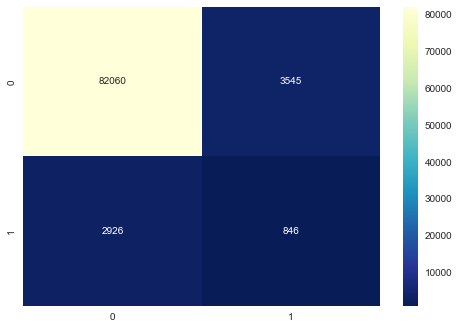

In [140]:
print(classification_report(y_test, train_predictions_xgb))
print("Test Fbeta score with higher weighted recall: ", fbeta_score(y_test, train_predictions_xgb, beta=2).round(3))
print("Test precision_score: ", precision_score(y_test, train_predictions_xgb))
print("Test roc_auc_score: ", roc_auc_score(y_test, train_predictions_xgb))
#roc_curve()

cm = confusion_matrix(y_test, train_predictions_xgb)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f")

   index                Feature  Importance
0     47  smart_187_raw_trigger    0.087229
1     39      smart_240_raw_ema    0.056941
2     18          smart_240_raw    0.056761
3     43    smart_5_raw_trigger    0.045496
4     15          smart_197_raw    0.039474
5      7          smart_184_raw    0.039375
6     25        smart_9_raw_ema    0.033089
7     55              smart_999    0.032648
8     46  smart_184_raw_trigger    0.030904
9      4            smart_9_raw    0.029889
['smart_1_raw', 'smart_4_raw', 'smart_5_raw', 'smart_7_raw', 'smart_9_raw', 'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw', 'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw', 'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw', 'smart_1_raw_ema', 'smart_4_raw_ema', 'smart_5_raw_ema', 'smart_7_raw_ema', 'smart_9_raw_ema', 'smart_12_raw_ema', 'smart_183_raw_ema', 'smart_184_raw_ema', 'smart_187_r

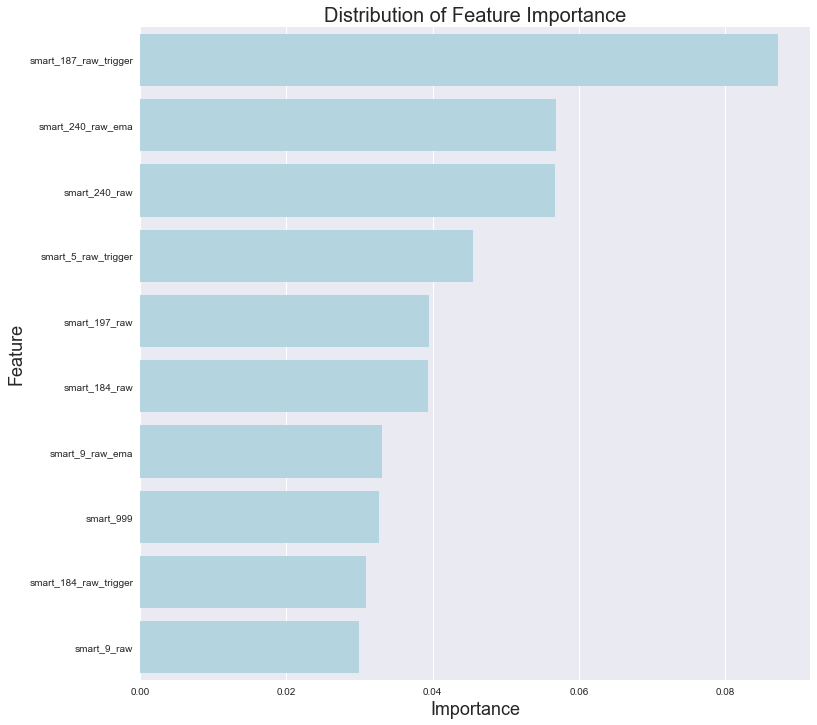

In [141]:
# Extract importance of features
importances_xgb = xgb_model.feature_importances_

# Create importance data frame and attach feature labels
model_importances_xgb = pd.DataFrame({"Feature": X_train.columns, "Importance": importances_xgb})

# Sort by ascending order
model_importances_xgb = model_importances_xgb.sort_values('Importance', ascending=False).reset_index().head(10)

# Plot as barplot
fig, ax = plt.subplots(figsize=(12,12), )
sns.barplot(y="Feature", x="Importance", data=model_importances_xgb, color = "lightblue")
plt.title('Distribution of Feature Importance', fontsize=20)
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)

print(model_importances_xgb)
print(list(X_train.columns[X_train.columns.str.contains("raw" or "smart")]))

### Grid Search for the models

In [ ]:
# # Define hyperparameters to be modified for Random Forest
# param_grid = { 
#     'n_estimators': [100, 200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8,10],
#     'criterion' :['gini', 'entropy']
# }

# # Perform Grid seach to find best hyperparameters
# GridSearch_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=RSEED, 
#                                n_jobs= -1, verbose = 1), 
#                                param_grid=param_grid, scoring=make_scorer(fbeta_score, beta=2), cv= 5)

# GridSearch_rf.fit(X_train_scaled, y_train)

# # Show best hyperparameters
# GridSearch_rf.best_params_

# # Fit gridsearch object to data.. also lets see how long it takes
# # start = timer()
# # end = timer()
# # gs_time = end-start
# # print(f"Grid search took {gs_time} seconds to run.")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.8s
[Parallel(n

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 500}

In [ ]:
# Show best hyperparameters Randomforest
print(GridSearch_rf.best_params_)

best_model = GridSearch_rf.best_estimator_

# # Training predictions
train_rf_predictions_best =  best_model.predict(X_train_scaled)
train_rf_probs_best =  best_model.predict_proba(X_train_scaled)[:, 1]

# Testing predictions (to determine performance)
rf_predictions_best =  best_model.predict(X_test_scaled)
rf_probs_best =  best_model.predict_proba(X_test_scaled)[:, 1]

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 500}


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    1.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed: 

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     85605
           1       0.34      0.12      0.17      3772

    accuracy                           0.95     89377
   macro avg       0.65      0.55      0.57     89377
weighted avg       0.94      0.95      0.94     89377

----------------------------------------------------------------------------------------------------
Fbeta score with higher weighted recall:  0.134
precision_score:  0.34328358208955223
roc_auc_score:  0.5530439369138742
----------------------------------------------------------------------------------------------------


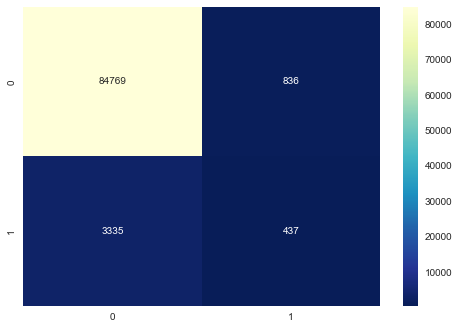

In [ ]:
#evaluation of the model
cm = confusion_matrix(y_test, rf_predictions_best)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

print(classification_report(y_test, rf_predictions_best))
print('----------'*10)
print("Fbeta score with higher weighted recall: ", fbeta_score(y_test, rf_predictions_best, beta=2).round(3))
print("precision_score: ", precision_score(y_test, rf_predictions_best))
print("roc_auc_score: ", roc_auc_score(y_test, rf_predictions_best))
print('----------'*10)

## Saving the model

In [151]:
#xgb_model
import sys

## in order to exemplify how the predict will work.. we will save the x/y_train (without preprocessing)
print("Saving test data in the data folder")
X_test.to_csv("../models/X_test.csv", index=False)
y_test.to_csv("../models/y_test.csv", index=False)

Saving test data in the data folder


In [148]:
print("Saving model in the model folder")
filename = '../models/xgb_model.sav'
pickle.dump(xgb_model, open(filename, 'wb'))


print('Number of arguments:', len(sys.argv), 'arguments.')
print('Argument List:', str(sys.argv)) 


Saving model in the model folder
Number of arguments: 3 arguments.
Argument List: ['/Users/andi/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/ipykernel_launcher.py', '-f', '/Users/andi/Library/Jupyter/runtime/kernel-c06baf69-6434-4058-ade1-83a27cc8cb78.json']
